<a href="https://colab.research.google.com/github/YvYh/FluxWeb/blob/main/Model_Controverses3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BQ**: Get/Load Data

In [7]:
from google.cloud import bigquery
json_path = 'poc-bigdata.json'
bigquery_client = bigquery.Client.from_service_account_json(json_path)

In [8]:
def get_bq_data(query):
  query_job = bigquery_client.query(query)
  rows = query_job.result()
  data = rows.to_dataframe()
  return data

In [9]:
def bq_load_df(name, df):
    dataset_ref = bigquery_client.dataset('FluxWeb_Prediction')
    table_ref = dataset_ref.table(name)
    
    
    job_config = bigquery.LoadJobConfig()
    job_config.write_disposition = bigquery.WriteDisposition.WRITE_APPEND
    if name == 'Controverses_bert':
      job_config.schema = get_bigquery_schema()
    else:
      job_config.autodetect=True
 
    load_job = bigquery_client.load_table_from_dataframe(
        df,
        table_ref,
        job_config=job_config)
 
    assert load_job.job_type == 'load'
 
    load_job.result()  # Waits for table load to complete.
 
    assert load_job.state == 'DONE'
    print('table {} load {} data.'.format(name, len(df)))

# **TensorFlow**:  TextVectorization

### Get Input Data

In [121]:
import numpy as np
import pandas as pd

In [122]:
 """SELECT DISTINCT NumControverse as label, Titre as Text
FROM `poc-bigdata.FluxWeb_Prediction.Controverses_prd`
UNION ALL 
SELECT DISTINCT NumControverse as label, Commentaire as Text
FROM `poc-bigdata.FluxWeb_Prediction.Controverses_prd`
WHERE Commentaire is not null and length(Commentaire)>5
UNION ALL 
SELECT DISTINCT NumControverse as label, Informations as Text
FROM `poc-bigdata.FluxWeb_Prediction.Controverses_prd`
WHERE Informations is not null
"""
q="SELECT label, Text FROM `poc-bigdata.FluxWeb_Prediction.Controverse_dataset`"
controverses = get_bq_data(q)

In [144]:
#controverses['Text_clean']=controverses.Text.apply(text_preprossing)
controverses = controverses[['label','Text']]

In [124]:
print(len(controverses))
print(len(controverses.label.unique()))
controverses.head()

11537
1408


,label,Text
0,2866,Révélation d'un scandale comptable survenu en ...
1,389,EPR de Flamanville: malfaçons
2,2543,Condamnation suite à des déversements dans des...
3,3506,Poursuites aux Etats-Unis en lien avec les émi...
4,3016,Incendie dans une usine de Lubrizol à Rouen


In [125]:
controverses['label'] = controverses['label'].astype('str')
controverses.label.dtypes

dtype('O')

In [126]:
controverses.label.sort_values().unique()

array(['1023', '1082', '1092', ..., '94', '952', '955'], dtype=object)

In [127]:
#label_index = {k: v for v, k in enumerate(controverses.label.sort_values().unique())}
#controverses.label = controverses.label.map(lambda x: label_index.get(x))

In [128]:
from sklearn.model_selection import train_test_split
#train, test = train_test_split(controverses, test_size=0.04)
train, val = train_test_split(controverses, test_size=0.1)
print(len(train), 'train examples')
print(len(val), 'validation examples')
#print(len(test), 'test examples')

10383 train examples
1154 validation examples


In [129]:
q="SELECT label, Text FROM `poc-bigdata.FluxWeb_Prediction.Controverse_dataset_test`"
test = get_bq_data(q)
print(len(test), 'test examples')

1254 test examples


In [130]:
test['label'] = test['label'].astype('str')

In [131]:
train.Text

6292     La firme a indiqué qu'elle décidera dans les p...
253      Les émetteurs de titres restaurant lourdement ...
180      La gamme AmazonBasics poserait des risques aux...
9525     Les deux parties se sont précédemment déjà réu...
1004     L'autorité allemande de la concurrence inflige...
                               ...                        
9403     Orange anciennement France Télécom, a été cond...
8592     Les tribus indigènes et les écologistes ont cr...
11482    La Commission européenne, par l'intermédiaire ...
1129     Endesa accusé d'avoir provoqué la mort de 255 ...
9940      La Swedbank et SEB font déjà l'objet d'une en...
Name: Text, Length: 10383, dtype: object

In [132]:
import tensorflow as tf

In [133]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('label')
  ds = tf.data.Dataset.from_tensor_slices((dataframe.Text, labels.values))
  #ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [134]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32
raw_train_ds = df_to_dataset(train)
raw_test_ds = df_to_dataset(test)
raw_val_ds= df_to_dataset(val)
raw_train_ds = raw_train_ds.prefetch(tf.data.AUTOTUNE)
raw_test_ds = raw_test_ds.prefetch(tf.data.AUTOTUNE)
raw_val_ds = raw_val_ds.prefetch(tf.data.AUTOTUNE)

In [135]:
for example, label in raw_train_ds.take(1):
  for i in range(3):
    print('texts: ', example.numpy()[i])
    print('labels: ', label.numpy()[i])

texts:  b"La banque dispose d'un d\xc3\xa9lai de vingt jours pour pr\xc3\xa9senter un plan de fermeture de sa succursale"
labels:  b'2348'
texts:  b"On ne sait pas pour le moment si d'autres pays sont concern\xc3\xa9s mais il est fort possible que ce soit le cas"
labels:  b'2572'
texts:  b"Un membre d'Animal Equality a travaill\xc3\xa9 de fa\xc3\xa7on dissimul\xc3\xa9e pour Moy Park qui d\xc3\xa9tient un tiers du march\xc3\xa9 de la volaille au Royaume-Uni et vend aux grandes surfaces comme Tesco et Ocado"
labels:  b'2942'


### Spacy

In [ ]:
!pip install -U spacy
!python -m spacy download fr_core_news_lg

In [ ]:
import spacy
nlp = spacy.load("fr_core_news_lg")

In [ ]:
def text_preprossing(text):
    tokens = nlp(text)
    clean = []
    for token in tokens:
        if not any([token.is_digit, token.is_punct, token.is_currency,
               token.like_url, token.like_num, token.like_email,
               token.is_stop]):
            clean += [token.lemma_]
    return tf.strings.join(clean, separator=' ')
    #return ' '.join(clean)

-------  
### Text preprocessing

In [29]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [30]:
text_list = train.Text.values.tolist()

In [31]:
vectorize_layer.adapt(text_list)

NameError: ignored

In [ ]:
vectorize_layer.get_vocabulary()

In [ ]:
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
embedding_layer = tf.keras.layers.Embedding(1000, 5)

In [ ]:

embedding_dim=1000

model = Sequential([
  vectorize_layer,
  Embedding(vocab_size, embedding_dim, name="embedding"),
  GlobalAveragePooling1D(),
  Dense(16, activation='relu'),
  Dense(1)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.fit(train_ds, 
          epochs=40, 
          validation_data=val_ds)

In [ ]:
model.summary()

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

#### tfidf model

In [ ]:
def text_preprossing2(text):
    tokens = nlp(text)
    clean = []
    for token in tokens:
        if not any([token.is_digit, token.is_punct, token.is_currency,
               token.like_url, token.like_num, token.like_email,
               token.is_stop]):
            clean += [token.lemma_]
    return tf.strings.join(clean, separator=' ')
    #return ' '.join(clean)

In [ ]:
vectorize_layer2 = TextVectorization(
    #standardize= text_preprossing,
    standardize='lower_and_strip_punctuation',
    max_tokens=vocab_size,
    output_mode='tf-idf',
    #output_sequence_length=sequence_length
    )

In [ ]:
vectorize_layer2.adapt(data.Text.values.tolist())

In [ ]:
tfidf = tf.keras.models.Sequential()
tfidf.add(tf.keras.Input(shape=(1,),dtype=tf.string))
tfidf.add(vectorize_layer2)

In [ ]:
tfidf.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
tfidf.fit(train.Text.values.tolist(), 
          epochs=40, 
          validation_data=val.Text.values.tolist())

In [ ]:
print(test.Text.values[0])
tfidf.predict([test.Text.values[0]])

In [ ]:
tfidf.save('tf_idf_model')
#reloaded_model = tf.keras.models.load_model('my_pet_classifier')

In [ ]:
news =''

input_dict = {'Text': tf.convert_to_tensor([news])}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This particular pet had a %.1f percent probability "
    "of getting adopted." % (100 * prob)
)

### Text Classification

In [ ]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
train_text = train_ds.map(lambda text,label: text)
train_text

<MapDataset shapes: (None, 1), types: tf.string>

In [ ]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(10):
    print("Text: ", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])

In [ ]:
!pip install -U spacy
!python -m spacy download fr_core_news_lg

In [ ]:
import spacy
nlp = spacy.load("fr_core_news_lg")

In [ ]:
def get_text(t: tf.Tensor):
  return t.numpy().decode('utf-8')
def text_preprossing(text: np.ndarray):
  result = []
  for t in text:
    tokens = nlp(t.decode('utf-8'))
    clean = []
    for token in tokens:
        if not any([token.is_digit, token.is_punct, token.is_currency,
              token.like_url, token.like_num, token.like_email,
              token.is_stop]):
            clean += [token.lemma_]
    #result = result+ [[tf.strings.join(clean, separator=' ')]]
    result = result+ [[' '.join(clean)]]
    #return ' '.join(clean)
    print(result)
  return tf.constant(result)
def clean_text(t: tf.Tensor):
  return tf.py_function(func=text_preprossing, inp=[t], Tout=tf.string)

In [ ]:
tf.config.run_functions_eagerly(False)

In [ ]:
test_text = test_ds.map(lambda text,label: text)
test = next(iter(test_text))
print(test)
clean_text(test)

tf.Tensor(
[[b"Ces enqu\xc3\xaates portaient sur l'embauche d'enfants de personnalit\xc3\xa9s chinoises et visaient plusieurs banques, soup\xc3\xa7onn\xc3\xa9es de les avoir recrut\xc3\xa9s, dans l'espoir d'obtenir des contrats"]
 [b"Apr\xc3\xa8s des \xc3\xa9meutes en 2016, d'autres violations ont eu lieu dans ce centre mais dans d'autres \xc3\xa9galement"]
 [b'Quatre groupes indig\xc3\xa8nes ont demand\xc3\xa9 \xc3\xa0 Frontera de nettoyer les dommages environnementaux li\xc3\xa9s aux d\xc3\xa9versements de p\xc3\xa9trole du Lot 192, le plus grand puits de p\xc3\xa9trole du P\xc3\xa9rou']
 [b"Edison a vers\xc3\xa9 500 $ par habitant et une enqu\xc3\xaate est en cours pour d\xc3\xa9terminer les causes de l'accident"]
 [b"La CFTC (US Commodity Futures Trading Commission) avait d\xc3\xa9pos\xc3\xa9 plainte contre Kraft Foods et Mondelez en Illinois en avril 2015, all\xc3\xa9guant que les soci\xc3\xa9t\xc3\xa9s avaient manipul\xc3\xa9 les prix du bl\xc3\xa9 (options) et du bl\xc3\xa9 (fut

UnknownError: ignored

In [ ]:
vocab_size = 10000
sequence_length = 600

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Set output_sequence_length length to pad all samples to same length.
vectorize_layer = TextVectorization(
    standardize= clean_text,
    #standardize='lower_and_strip_punctuation',
    max_tokens=vocab_size,
    output_mode='tf-idf',
    #output_sequence_length=sequence_length
    )

In [ ]:
vectorize_layer.adapt(train_text)

TypeError: ignored

### Binary classification

In [ ]:
VOCAB_SIZE = 10000

binary_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='binary')
train_text = train_ds.map(lambda text, labels: text)
binary_vectorize_layer.adapt(train_text)

In [ ]:
def binary_vectorize_text(text, label):
  #text = tf.expand_dims(text, -1)
  return binary_vectorize_layer(text), label

In [ ]:
# Retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(train_ds))
first_text, first_label = text_batch[0], label_batch[0]
print("Text", first_text)
print("Label", first_label)

Text tf.Tensor([b'D\xc3\xa8s lors le groupe devra payer 50000? par emploi non cr\xc3\xa9\xc3\xa9.'], shape=(1,), dtype=string)
Label tf.Tensor(1623, shape=(), dtype=int64)


In [ ]:
print("'binary' vectorized question:", 
      binary_vectorize_text(first_text, first_label)[0])

'binary' vectorized question: tf.Tensor([[0. 0. 0. ... 0. 0. 0.]], shape=(1, 10000), dtype=float32)


In [ ]:
binary_train_ds = train_ds.map(binary_vectorize_text)
binary_val_ds = val_ds.map(binary_vectorize_text)
binary_test_ds = test_ds.map(binary_vectorize_text)
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
def configure_dataset(dataset):
  return dataset.cache().prefetch(buffer_size=AUTOTUNE)
binary_train_ds = configure_dataset(binary_train_ds)
binary_val_ds = configure_dataset(binary_val_ds)
binary_test_ds = configure_dataset(binary_test_ds)
binary_model = tf.keras.Sequential([layers.Dense(1408)])
binary_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])
history = binary_model.fit(
    binary_train_ds, validation_data=binary_val_ds, epochs=10)

Epoch 1/10
312/312 [==============================] - 30s 93ms/step - loss: 7.0292 - accuracy: 0.0339 - val_loss: 6.7537 - val_accuracy: 0.0532
Epoch 2/10
312/312 [==============================] - 28s 90ms/step - loss: 5.1791 - accuracy: 0.3137 - val_loss: 6.3566 - val_accuracy: 0.1011
Epoch 3/10
312/312 [==============================] - 28s 90ms/step - loss: 3.8214 - accuracy: 0.7078 - val_loss: 6.1175 - val_accuracy: 0.1399
Epoch 4/10
312/312 [==============================] - 28s 90ms/step - loss: 2.8739 - accuracy: 0.8757 - val_loss: 5.9865 - val_accuracy: 0.1661
Epoch 5/10
312/312 [==============================] - 28s 89ms/step - loss: 2.2497 - accuracy: 0.9243 - val_loss: 5.9243 - val_accuracy: 0.1742
Epoch 6/10
312/312 [==============================] - 28s 90ms/step - loss: 1.8262 - accuracy: 0.9382 - val_loss: 5.9035 - val_accuracy: 0.1787
Epoch 7/10
312/312 [==============================] - 28s 91ms/step - loss: 1.5233 - accuracy: 0.9460 - val_loss: 5.9084 - val_accuracy:

In [ ]:
print("Linear model on binary vectorized data:")
print(binary_model.summary())

Linear model on binary vectorized data:
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1408)              14081408  
Total params: 14,081,408
Trainable params: 14,081,408
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
binary_loss, binary_accuracy = binary_model.evaluate(binary_test_ds)
print("Binary model accuracy: {:2.2%}".format(binary_accuracy))

15/15 [==============================] - 1s 29ms/step - loss: 6.2363 - accuracy: 0.1537
Binary model accuracy: 15.37%


In [ ]:
export_model = tf.keras.Sequential(
    [binary_vectorize_layer, binary_model,
     layers.Activation('sigmoid')])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(test_ds)
print("Accuracy: {:2.2%}".format(binary_accuracy))

15/15 [==============================] - 1s 33ms/step - loss: 6.2363 - accuracy: 0.1537
Accuracy: 15.37%


In [ ]:
def get_string_labels(predicted_scores_batch):
  predicted_ints = tf.argmax(predicted_scores_batch, axis=1).numpy()
  return [[k for k,v in label_index.items() if v == i][0] for i in predicted_ints]

In [ ]:
predicted_int_labels.numpy()

array([16])

In [ ]:
[k for k,v in label_index.items() if v == 16][0]

389

In [ ]:
inputs=["EPR de Flamanville: malfaçons",
        "Redressement fiscal des GAFAM en France"]
predicted_scores = export_model.predict(inputs)
predicted_labels = get_string_labels(predicted_scores)
for input, label in zip(inputs, predicted_labels):
  print("Text: ", input)
  print("Predicted label: ", label)

Text:  EPR de Flamanville: malfaçons
Predicted label:  389
Text:  Redressement fiscal des GAFAM en France
Predicted label:  2019


In [ ]:
export_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_16 (TextV (None, 10000)             0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 1408)              14081408  
_________________________________________________________________
activation (Activation)      (None, 1408)              0         
Total params: 14,081,408
Trainable params: 14,081,408
Non-trainable params: 0
_________________________________________________________________


In [ ]:
export_model.save('binaryClassif')

INFO:tensorflow:Assets written to: binaryClassif/assets


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pd.DataFrame({'label':label_index.values(), 'numControverse':label_index.keys()})

,label,numControverse
0,0,23
1,1,57
2,2,64
3,3,69
4,4,77
...,...,...
1403,1403,3611
1404,1404,3612
1405,1405,3613
1406,1406,3614


In [ ]:
bq_load_df("LabelControv", pd.DataFrame({'label':label_index.values(), 'numControverse':label_index.keys()}))

table LabelControv load 1408 data.


### Multi-class Classification

In [118]:
import matplotlib.pyplot as plt
import string

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [45]:
max_features = 100000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=max_features,
    output_mode='int',
    #output_mode='tf-idf',
    output_sequence_length=sequence_length
    )

In [102]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [42]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [103]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [49]:
len(controverses.label.unique())

1408

In [50]:
embedding_dim = 16

In [115]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          1600016   
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_4 ( (None, 16)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 1,600,033
Trainable params: 1,600,033
Non-trainable params: 0
_________________________________________________________________


In [116]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [111]:
train_ds

<MapDataset shapes: ((None, 250), (None,)), types: (tf.int64, tf.string)>

In [117]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


UnimplementedError: ignored

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

### Text Classification Guide

In [158]:
q="SELECT label, Text FROM `poc-bigdata.FluxWeb_Prediction.Controverse_dataset`"
controverses = get_bq_data(q)
q="SELECT label, Text FROM `poc-bigdata.FluxWeb_Prediction.Controverse_dataset_test`"
test = get_bq_data(q)

In [176]:
label_index = {k: v for v, k in enumerate(controverses.append(test,ignore_index=True).label.sort_values().unique())}
controverses.label = controverses.label.map(lambda x: label_index.get(x))
test.label = test.label.map(lambda x: label_index.get(x))

In [180]:
print(len(controverses))
print(len(test))
data = ((controverses.Text.values.tolist(),controverses.label.values), 
        (test.Text.values.tolist(),test.label.values))

11537
1254


In [160]:
import numpy as np
import matplotlib.pyplot as plt

def get_num_words_per_sample(sample_texts):
    """Returns the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

20.0


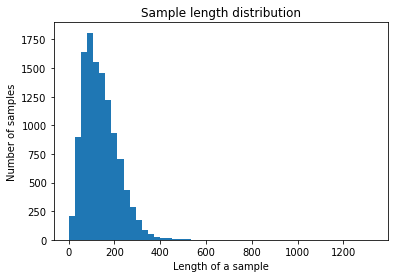

In [162]:
num_words = get_num_words_per_sample(controverses.Text.values.tolist())
print(num_words)
plot_sample_length_distribution(controverses.Text.values.tolist())

In [163]:
def get_num_classes(labels):
    """Gets the total number of classes.
    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    # Returns
        int, total number of classes.
    # Raises
        ValueError: if any label value in the range(0, num_classes - 1)
            is missing or if number of classes is <= 1.
    """
    num_classes = max(labels) + 1
    missing_classes = [i for i in range(num_classes) if i not in labels]
    if len(missing_classes):
        raise ValueError('Missing samples with label value(s) '
                         '{missing_classes}. Please make sure you have '
                         'at least one sample for every label value '
                         'in the range(0, {max_class})'.format(
                            missing_classes=missing_classes,
                            max_class=num_classes - 1))

    if num_classes <= 1:
        raise ValueError('Invalid number of labels: {num_classes}.'
                         'Please make sure there are at least two classes '
                         'of samples'.format(num_classes=num_classes))
    return num_classes

In [120]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

In [151]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

In [141]:
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model

In [197]:
def train_ngram_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
    num_classes = get_num_classes(train_labels)
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                          ' {unexpected_labels}. Please make sure that the '
                          'labels in the validation set are in the same range '
                          'as training labels.'.format(
                              unexpected_labels=unexpected_labels))

    # Vectorize texts.
    x_train, x_val = ngram_vectorize(
        train_texts, train_labels, val_texts)

    # Create model instance.
    model = mlp_model(layers=layers,
                      units=units,
                      dropout_rate=dropout_rate,
                      input_shape=x_train.shape[1:],
                      num_classes=num_classes)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    #optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer='adam', loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('Controverses_Classification')
    return history['val_acc'][-1], history['val_loss'][-1]

In [198]:
val_acc, val_loss = train_ngram_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:1817: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Epoch 1/1000


TypeError: ignored

In [189]:
learning_rate=1e-3
epochs=1000
batch_size=128
layers=2
units=1407
dropout_rate=0.2

In [183]:
(train_texts, train_labels), (val_texts, val_labels) = data

In [184]:
num_classes = get_num_classes(train_labels)
unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
if len(unexpected_labels):
    raise ValueError('Unexpected label values found in the validation set:'
                      ' {unexpected_labels}. Please make sure that the '
                      'labels in the validation set are in the same range '
                      'as training labels.'.format(
                          unexpected_labels=unexpected_labels))

In [185]:
x_train, x_val = ngram_vectorize(
    train_texts, train_labels, val_texts)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:1817: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


In [ ]:
model = mlp_model(layers=layers,
                      units=units,
                      dropout_rate=dropout_rate,
                      input_shape=x_train.shape[1:],
                      num_classes=num_classes)

In [194]:
loss = 'sparse_categorical_crossentropy'
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer='adam', loss=loss, metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [195]:
callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

In [201]:
x_val

<1254x20000 sparse matrix of type '<class 'numpy.float32'>'
	with 26467 stored elements in Compressed Sparse Row format>

In [196]:
history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

Epoch 1/1000


TypeError: ignored